# Deep Q-Learning

Q関数をニューラルネットで近似したもの。ほかにもTarget Networt, Experience Replayなど工夫が入っている。


In [1]:
from collections import namedtuple, deque
from itertools import count
import random
import copy

import gym
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

plt.rcParams['font.family'] = 'MyricaM M'

In [2]:
# ハイパラ
BATCH_SIZE = 64
N_EPISODES = 600
TARGET_UPDATE_FREQ = 100
N_HIDDEN = 64
REPLAY_MEMORY_SIZE = 10**4
REPLAY_START_SIZE = 500
MIN_EPS = 0.01
EPS_DECAY = 5000

env = gym.make('CartPole-v0')
obs_size = env.observation_space.low.size
n_actions = env.action_space.n
reword_threshold = env.spec.reward_threshold

np.random.seed(125)
env.seed(125)
torch.manual_seed(125)

In [3]:
class QNetwork(nn.Module):
    def __init__(self, in_dim, n_actions, h_dim=64):
        super(QNetwork, self).__init__()
        self.h1 = nn.Linear(in_dim, h_dim)
        self.h2 = nn.Linear(h_dim, n_actions)
    
    def forward(self, x):
        h = F.relu(self.h1(x))
        return self.h2(h)

In [4]:
class EpsilonGreedy():
    def __init__(self, n_actions):
        self.n_actions = n_actions
    
    def sample(self, q_net, obs, iteration, len_mem):
        # epsilonを線形に減ずる
        if len_mem < REPLAY_START_SIZE:
            epsilon = 1.0
        else:
            epsilon = max(MIN_EPS, np.interp(iteration, [0, EPS_DECAY], [1.0, MIN_EPS]))

        # epsilon-greedyで行動を選択
        if np.random.rand() < epsilon:
            action = np.random.randint(low=0, high=self.n_actions)
        else:
            obs_t = torch.from_numpy(obs).float()
            with torch.no_grad():
                action = int(torch.argmax(policy_q(obs_t)))
        
        return action

In [5]:
def ep_greedy(Q, state, num_iter, len_memory):
    # epsilonを線形に減ずる
    if len_memory < REPLAY_START_SIZE:
        epsilon = 1.0
    else:
        epsilon = max(MIN_EPS, np.interp(num_iter, [0, EPS_DECAY], [1.0, MIN_EPS]))

    # epsilon-greedyで行動を選択
    if np.random.rand() < epsilon:
        action = np.random.randint(low=0, high=n_actions) # ランダムに行動
    else:
        state_t = torch.from_numpy(state).float()
        with torch.no_grad():
            action = int(torch.argmax(Q(state_t)))
    
    return action

In [6]:
def update_policy(policy_q, target_q, optimizer, samples, gamma=0.99):

    state = torch.Tensor([sample[0] for sample in samples]).float()
    action = torch.LongTensor([[sample[1]] for sample in samples])
    reward = torch.Tensor([sample[2] for sample in samples]).float()
    done = torch.Tensor([sample[3] for sample in samples]).float()
    n_state = torch.Tensor([sample[4] for sample in samples]).float()

    # 現在のQnetによる、Q(s, a)の推定値
    Q_sa = policy_q(state).gather(1, action)
    
    # 実際に行動した結果の実績値（target, r+gamma * max_a' Q(s', a')）
    # - 勾配が残らないようにするためのdetach()
    # - max(axis)の返り値は(value, indices)なので、[0]をつける
    next_Q = target_q(n_state).max(axis=1)[0].detach() 
    target = reward + gamma * (1 - done) * next_Q 

    # Huber lossを計算
    # - unsqueeze()で次元を増やす
    loss = F.smooth_l1_loss(Q_sa, target.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy_q.parameters():
        param.grad.data.clamp_(-1, 1) # 勾配クリッピング
    optimizer.step()



In [7]:
policy_q = QNetwork(obs_size, n_actions)
target_q = QNetwork(obs_size, n_actions)
target_q.load_state_dict(policy_q.state_dict()) # パラメータのコピー
target_q.eval() # target_qは更新しない
optimizer = optim.Adam(policy_q.parameters())
replay_mem = deque(maxlen=REPLAY_MEMORY_SIZE)
epsilon_greedy = EpsilonGreedy(n_actions)
Rs = deque(maxlen=100)
hist_aveRs = []

iteration = 0
for ep in range(N_EPISODES):
    state = env.reset()
    done = False
    R = 0
    timestep = 0

    while not done:
        # epsilon-greedyで行動選択
        action = ep_greedy(policy_q, state, iteration, len(replay_mem))
        # action = epsilon_greedy.sample(policy_q, state, iteration, len(replay_mem))
        next_state, reward, done, _ = env.step(action)
        R += reward

        # 状態遷移を保存
        replay_mem.append((state, action, reward, done, next_state))

        # 状態の更新
        state = next_state

        # Experience Replay
        if len(replay_mem) >= REPLAY_START_SIZE:
            sample_indices = random.sample(range(len(replay_mem)), BATCH_SIZE)
            samples = [replay_mem[i] for i in sample_indices]
            update_policy(policy_q, target_q, optimizer, samples)

        # target networkの更新（pytorchのサンプルは5episodeごとに更新）
        if iteration % TARGET_UPDATE_FREQ == 0:
            target_q.load_state_dict(policy_q.state_dict())
        
        iteration += 1
        timestep += 1
    
    Rs.append(R)
    average_R = np.mean(Rs)
    hist_aveRs.append(average_R)
    if ep % 10 == 0:
        print('episodes: {} iteration: {} R: {} average_R {}'.format(ep, iteration, R, average_R))

episodes: 0 iteration: 28 R: 28.0 average_R 28.0
episodes: 10 iteration: 229 R: 35.0 average_R 20.818181818181817
episodes: 20 iteration: 432 R: 39.0 average_R 20.571428571428573
episodes: 30 iteration: 653 R: 22.0 average_R 21.06451612903226
episodes: 40 iteration: 845 R: 22.0 average_R 20.609756097560975
episodes: 50 iteration: 1036 R: 27.0 average_R 20.313725490196077
episodes: 60 iteration: 1202 R: 12.0 average_R 19.704918032786885
episodes: 70 iteration: 1371 R: 28.0 average_R 19.309859154929576
episodes: 80 iteration: 1521 R: 18.0 average_R 18.77777777777778
episodes: 90 iteration: 1694 R: 15.0 average_R 18.615384615384617
episodes: 100 iteration: 1839 R: 14.0 average_R 18.11
episodes: 110 iteration: 2046 R: 14.0 average_R 18.17
episodes: 120 iteration: 2175 R: 11.0 average_R 17.43
episodes: 130 iteration: 2367 R: 20.0 average_R 17.14
episodes: 140 iteration: 3062 R: 52.0 average_R 22.17
episodes: 150 iteration: 3993 R: 81.0 average_R 29.57
episodes: 160 iteration: 5290 R: 200.0 

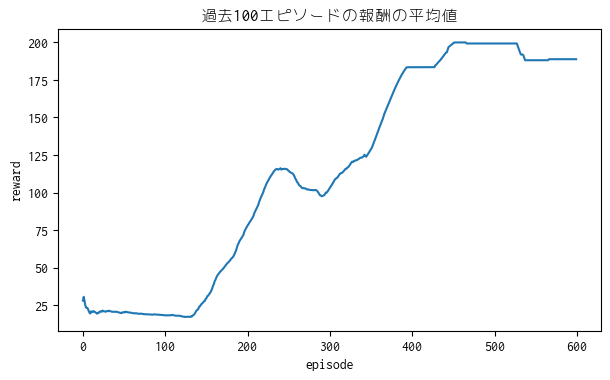

In [13]:
fig, ax = plt.subplots(figsize=(7, 4), dpi=100)
ax.plot(hist_aveRs)
ax.set_title('過去100エピソードの報酬の平均値')
ax.set_xlabel('episode')
ax.set_ylabel('reward')
plt.savefig('images/dqn_train.png')
plt.show()

In [9]:
env.close()

## テスト

In [10]:
state = env.reset()
done = False
R = 0
timestep = 0

while not done and timestep < env.spec.max_episode_steps:
    env.render()

    action = epsilong_greedy.sample(policy_q, state, iteration, len(replay_mem))
    n_state, reward, done, _ = env.step(action)
    R += reward

    # 状態の更新
    state = n_state

env.close()

NameError: name 'epsilong_greedy' is not defined

In [11]:
# モデルの保存
# torch.save(policy_q.state_dict(), './data/model/dqn_cartpole.pth')

In [12]:
env.close()